# Trading at the Close - Hyperparameter Optimization
-----------------------
-----------------------


This notebook is intended to be run after the preprocessing notebook. Provided that LGBM does a good job in fitting this dataset, we'll use the LGBMRegressor and Optuna to find good hyperparameters.

## Installs
-------------

In [1]:
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sys
import numpy as np
from pathlib import Path
from loguru import logger
from pprint import pformat
import pandas as pd
import json
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer
from IPython.display import clear_output
import optuna
from optuna.samplers import TPESampler, CmaEsSampler
from optuna.pruners import MedianPruner, HyperbandPruner
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
)

from utils.validation import TrainTestSplit

optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style("ticks")

c:\Users\salva\OneDrive\Documentos\Python Projects\trading-at-the-close\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class CFG:
    JOBS_PATH = Path(".", "job_artifacts")
    JOB_NAME = "optiver-tuning_lgbmregressor"
    TRAINING_PATH = Path(".", "train_files", "train.csv")
    FEATURES_PATH = JOBS_PATH.joinpath("optiver-feature_selection-0106")
    FEATURES_NAME = "feature_names.json"
    BEST_PARAMS = "best_params.json"
    RANDOM_STATE = 42
    USE_GPU = False
    MODEL = LGBMRegressor
    SAMPLER = CmaEsSampler
    PRUNER = HyperbandPruner
    USE_BEST = True
    JOB_PATH_BEST = JOBS_PATH.joinpath("optiver-tuning_lgbmregressor-0009")
    HYPERTUNE = True
    PRELOAD_STUDY = False
    TEST_SIZE = 45
    N_FOLDS = 1
    N_TRIALS = 50
    N_JOBS = 4

In [4]:
def lgbm_param_space(trial):
    """Returns the parameter space of a LGBMRegressor."""
    # num_leaves should be smaller than 2^{max_depth}
    max_depth = trial.suggest_int("max_depth", 5, 12)
    num_leaves = trial.suggest_int("num_leaves", 8, int((2**max_depth) * 0.75))
    #num_leaves = trial.suggest_int("num_leaves", 8, 64)

    param_space = {
        "device": trial.suggest_categorical("device", ["gpu" if CFG.USE_GPU else "cpu"]),
        "verbose": trial.suggest_categorical("verbose", [-1]),
        "n_jobs": trial.suggest_categorical("n_jobs", [1]),
        "objective": trial.suggest_categorical("objective", ["mae"]),
        "n_estimators": trial.suggest_categorical("n_estimators", [750]), # automatically via early stopping
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
        "num_leaves": num_leaves,
        "max_depth": max_depth
    }

    return param_space



def lgbm_callbacks(trial):
    """Returns the callbacks for a LGBMRegressor."""
    optuna_prune = optuna.integration.LightGBMPruningCallback(trial, "l1", report_interval=100)
    inner_early_stop = lgb.early_stopping(25, verbose=False)

    return [inner_early_stop]
    #return [optuna_prune, inner_early_stop]


MODEL_CFG = {
    LGBMRegressor.__name__ : {
        "param_space": lgbm_param_space,
        "callbacks": lgbm_callbacks
    }
}  

In [5]:
CFG.JOBS_PATH.mkdir(exist_ok=True, parents=True)

for i in range(1, 10000):
    CFG.JOB_PATH = CFG.JOBS_PATH.joinpath(CFG.JOB_NAME + "-" +  str(i).zfill(4))
    try:
        CFG.JOB_PATH.mkdir()
        break
    except:
        continue

## Data Loading
---------------

In the next cell, we define code to load the data and to generate features with optional memory reduction. It uses functions that are written to file by running `%%writefile` in `preprocessing.ipynb`.

In [6]:
from utils.features import feature_engineering, clean_dataset, select_features
from utils.files import read_json

df = pd.read_csv(CFG.TRAINING_PATH)
features = read_json(CFG.FEATURES_PATH.joinpath(CFG.FEATURES_NAME))
selected_features = features["selected_features"]
stock_weights = np.array([
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
])

# Do feature engineering
df = feature_engineering(df, weights=stock_weights, reduce_memory=True)

# Clean dataset
clean_dataset(df)

# Extract date ID
date_id = df["date_id"]

# Select features
df = select_features(df, selected_features, reduce_memory=False)


Y = df["target"]
X = df.drop(columns=["target"], errors="ignore")

del df

2023-11-05 01:50:27.858 | INFO     | utils.features:feature_engineering:195 - Generating time features...
2023-11-05 01:50:27.859 | INFO     | utils.features:feature_engineering:201 - Generating size features...
2023-11-05 01:50:28.034 | INFO     | utils.features:feature_engineering:207 - Generating price features...
2023-11-05 01:51:11.375 | INFO     | utils.features:feature_engineering:213 - Generating mixed features...
2023-11-05 01:51:11.395 | INFO     | utils.features:feature_engineering:219 - Generating aggregated features...
2023-11-05 01:54:38.988 | INFO     | utils.features:feature_engineering:225 - Generating rolling features...
2023-11-05 01:54:39.529 | INFO     | utils.features:feature_engineering:235 - Reducing data memory footprint...
2023-11-05 01:54:39.599 | INFO     | utils.compression:downcast:16 - Memory usage of dataframe is 3596.64 MB
2023-11-05 01:55:03.585 | INFO     | utils.compression:downcast:25 - Memory usage after optimization is: 2342.81 MB
2023-11-05 01:55

## Hyperparameter Optimization
-----------------------------------

### Setup the evaluation process

We have many options, but we'll stick with cross-validation schemes even though these are more expensive to tune. This is because it yields more robust estimations of mean absolute error.


In [7]:
from utils.validation import cross_validate

### Optimization specifics

We define a convenience function `run_optimization`, that starts the optimization process given a objective function.

The objective function is returned by the `get_objective_function` method. Inside this method, the parameter space is defined using the optuna `trial` object.

In [8]:
# Optimization runner
def run_optimization(objective, n_trials=100, sampler=TPESampler(), pruner=MedianPruner(), n_jobs=1, best_trial=None):
    """Run the given objective with Optuna and return the study results."""

    study_name = "optuna-study"
    storage = "sqlite:///" + str(CFG.JOB_PATH.joinpath(study_name)) + ".sqlite3"
    logger.info(f"Creating study...")


    if CFG.PRELOAD_STUDY:
        study = optuna.load_study(
            study_name=study_name, 
            sampler=sampler,
            pruner=pruner,
            storage=storage
        )

    else:
        try:
            optuna.study.delete_study(
                study_name=study_name,
                storage=storage
            )
        except:
            logger.warning(f"Study does not exist...")

        study = optuna.create_study(
            study_name=study_name, 
            direction="minimize", 
            sampler=sampler,
            pruner=pruner,
            storage=storage
        )

    if best_trial is not None:
        logger.info("Enqueuing previous best trial ...")
        study.enqueue_trial(best_trial)

    logger.info(f"Running hyperparameter search...")
    study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs, show_progress_bar=True)

    logger.info(f"Number of finished trials: {len(study.trials)}")
    logger.success(f"Best MAE: {study.best_value:.4f}")

    logger.info("Parameters: ")
    logger.info("=" * 10)
    logger.success(pformat(study.best_params, indent=4))

    logger.info(f"Saving best parameters...")
    with open("best_params.json", "w") as f:
        json.dump(study.best_params, f)
    return study

In [9]:
def get_objective_function(model_cls, param_func, x, y, date_id, cv=TimeSeriesSplit(), callbacks_func=None, *args, **kwargs):
    """Returns the objective function for optuna."""
        
    def objective_function(trial):
        """Optimizes a model with cross-validation."""

        param_space = param_func(trial)
        callbacks = callbacks_func(trial) if callbacks_func is not None else None  
        scores, _ = cross_validate(model_cls, param_space, x, y, date_id=date_id, cv=cv, callbacks=callbacks, *args, **kwargs)
        return scores.mean()

    return objective_function

### Start the optimization

We can set these variables here:
1. `run_optimization`: Whether to run the optimization or use already computed ones.
2. `n_trials`: How many trials we want to sample.
3. `cv`: the Split object.
4. `best_trial`: whether to reuse a previously tuned best trial for this optimization.

*Warning*: `evaluation='cross_validate'` takes very long!

In [10]:
from utils.files import read_json

if CFG.USE_BEST:
    best_params = read_json(CFG.JOB_PATH_BEST.joinpath(CFG.BEST_PARAMS))

In [11]:
from utils.files import dump_json

model_cls = CFG.MODEL
model_cfg = MODEL_CFG[CFG.MODEL.__name__]
param_space_func = model_cfg["param_space"]
callbacks_func = model_cfg["callbacks"]
best_trial = best_params if CFG.USE_BEST else None

clear_output(wait=True) # clears output before rerunning optimization

if CFG.HYPERTUNE:
    objective = get_objective_function(
        model_cls, 
        param_space_func, 
        X, Y, 
        date_id=date_id,
        cv=TrainTestSplit(test_size=CFG.TEST_SIZE, n_splits=CFG.N_FOLDS),
        categorical_feature=["imbalance_buy_sell_flag"],
        callbacks_func=callbacks_func
    )
    study = run_optimization(
        objective, 
        sampler=CFG.SAMPLER(), 
        pruner=CFG.PRUNER(), 
        n_trials=CFG.N_TRIALS, 
        n_jobs=CFG.N_JOBS, 
        best_trial=best_trial
    )
    best_params = study.best_params
    dump_json(CFG.JOB_PATH.joinpath(CFG.BEST_PARAMS), best_params, indent=4)

2023-11-05 01:55:09.872 | INFO     | __main__:run_optimization:7 - Creating study...


2023-11-05 01:55:10.892 | WARNING  | __main__:run_optimization:25 - Study does not exist...
2023-11-05 01:55:10.943 | INFO     | __main__:run_optimization:36 - Enqueuing previous best trial ...
2023-11-05 01:55:10.958 | INFO     | __main__:run_optimization:39 - Running hyperparameter search...
  0%|          | 0/50 [00:00<?, ?it/s]2023-11-05 01:55:11.359 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 01:55:11.359 | INFO     | utils.validation:cross_validate:82 - ==============================
2023-11-05 01:55:12.001 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 01:55:12.002 | INFO     | utils.validation:cross_validate:82 - ==============================
2023-11-05 01:55:12.002 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 01:55:12.017 | INFO     | utils.validation:cross_validate:82 - ==============================
2023-11-05 01:55:12.037 | INFO     | utils.validation:cross_v

[W 2023-11-05 02:11:36,968] The parameter 'num_leaves' in trial#5 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:15:26.925 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8532 (took 216.08s)
2023-11-05 02:15:26.947 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:15:26.947 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8532 ± 0.00
2023-11-05 02:15:26.947 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 3. Best value: 5.8485:   6%|▌         | 3/50 [20:16<4:26:33, 340.28s/it]2023-11-05 02:15:27.482 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:15:27.482 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 02:15:27,376] The parameter 'num_leaves' in trial#6 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:19:59.625 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8456 (took 1420.23s)
2023-11-05 02:19:59.647 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:19:59.647 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8456 ± 0.00
2023-11-05 02:19:59.647 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 0. Best value: 5.84556:   8%|▊         | 4/50 [24:48<4:00:24, 313.58s/it]2023-11-05 02:20:00.144 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:20:00.146 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 02:20:00,036] The parameter 'num_leaves' in trial#7 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:21:10.084 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8492 (took 1484.67s)
2023-11-05 02:21:10.103 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:21:10.105 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8492 ± 0.00
2023-11-05 02:21:10.105 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 0. Best value: 5.84556:  10%|█         | 5/50 [25:59<2:49:25, 225.91s/it]

[W 2023-11-05 02:21:10,782] The parameter 'num_leaves' in trial#8 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:21:11.163 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:21:11.165 | INFO     | utils.validation:cross_validate:82 - ==============================
2023-11-05 02:21:55.760 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8520 (took 366.91s)
2023-11-05 02:21:55.784 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:21:55.787 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8520 ± 0.00
2023-11-05 02:21:55.787 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 0. Best value: 5.84556:  12%|█▏        | 6/50 [26:45<2:00:45, 164.68s/it]2023-11-05 02:21:56.482 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:21:56.482 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 02:21:56,331] The parameter 'num_leaves' in trial#9 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:24:50.822 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8521 (took 207.29s)
2023-11-05 02:24:50.844 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:24:50.844 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8521 ± 0.00
2023-11-05 02:24:50.844 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 0. Best value: 5.84556:  14%|█▍        | 7/50 [29:40<2:00:26, 168.07s/it]

[W 2023-11-05 02:24:51,628] The parameter 'num_leaves' in trial#10 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:24:52.082 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:24:52.084 | INFO     | utils.validation:cross_validate:82 - ==============================
2023-11-05 02:25:32.483 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8458 (took 927.66s)
2023-11-05 02:25:32.513 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:25:32.515 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8458 ± 0.00
2023-11-05 02:25:32.516 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 0. Best value: 5.84556:  16%|█▌        | 8/50 [30:22<1:29:29, 127.86s/it]2023-11-05 02:25:33.222 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:25:33.223 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 02:25:33,122] The parameter 'num_leaves' in trial#11 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:30:47.883 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8528 (took 339.48s)
2023-11-05 02:30:47.904 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:30:47.904 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8528 ± 0.00
2023-11-05 02:30:47.911 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 0. Best value: 5.84556:  18%|█▊        | 9/50 [35:37<2:07:23, 186.44s/it]2023-11-05 02:30:48.480 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:30:48.481 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 02:30:48,371] The parameter 'num_leaves' in trial#12 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:31:57.836 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8467 (took 566.55s)
2023-11-05 02:31:57.857 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:31:57.859 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8467 ± 0.00
2023-11-05 02:31:57.860 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 0. Best value: 5.84556:  20%|██        | 10/50 [36:47<1:40:19, 150.48s/it]2023-11-05 02:31:58.432 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:31:58.432 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 02:31:58,327] The parameter 'num_leaves' in trial#13 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:34:34.320 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8466 (took 515.70s)
2023-11-05 02:34:34.348 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:34:34.355 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8466 ± 0.00
2023-11-05 02:34:34.356 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 0. Best value: 5.84556:  22%|██▏       | 11/50 [39:23<1:39:00, 152.31s/it]2023-11-05 02:34:34.916 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:34:34.918 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 02:34:34,806] The parameter 'num_leaves' in trial#14 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:35:50.384 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8509 (took 912.63s)
2023-11-05 02:35:50.411 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:35:50.413 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8509 ± 0.00
2023-11-05 02:35:50.414 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 0. Best value: 5.84556:  24%|██▍       | 12/50 [40:39<1:21:46, 129.13s/it]2023-11-05 02:35:51.007 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:35:51.007 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 02:35:50,898] The parameter 'num_leaves' in trial#15 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:40:23.156 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8511 (took 480.83s)
2023-11-05 02:40:23.180 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:40:23.182 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8511 ± 0.00
2023-11-05 02:40:23.183 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 0. Best value: 5.84556:  26%|██▌       | 13/50 [45:12<1:46:27, 172.63s/it]2023-11-05 02:40:23.754 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:40:23.756 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 02:40:23,618] The parameter 'num_leaves' in trial#16 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:46:15.749 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8491 (took 669.57s)
2023-11-05 02:46:15.771 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:46:15.772 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8491 ± 0.00
2023-11-05 02:46:15.774 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 0. Best value: 5.84556:  28%|██▊       | 14/50 [51:05<2:16:11, 226.99s/it]2023-11-05 02:46:16.366 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:46:16.366 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 02:46:16,261] The parameter 'num_leaves' in trial#17 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:49:09.198 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8469 (took 1050.90s)
2023-11-05 02:49:09.221 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:49:09.222 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8469 ± 0.00
2023-11-05 02:49:09.223 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 0. Best value: 5.84556:  30%|███       | 15/50 [53:58<2:02:59, 210.85s/it]2023-11-05 02:49:09.779 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:49:09.780 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 02:49:09,679] The parameter 'num_leaves' in trial#18 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:51:26.219 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8514 (took 893.66s)
2023-11-05 02:51:26.247 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:51:26.249 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8514 ± 0.00
2023-11-05 02:51:26.250 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 0. Best value: 5.84556:  32%|███▏      | 16/50 [56:15<1:46:53, 188.63s/it]2023-11-05 02:51:26.844 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:51:26.851 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 02:51:26,739] The parameter 'num_leaves' in trial#19 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:52:09.956 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8479 (took 673.36s)
2023-11-05 02:52:09.977 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:52:09.979 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8479 ± 0.00
2023-11-05 02:52:09.980 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 0. Best value: 5.84556:  34%|███▍      | 17/50 [56:59<1:19:47, 145.07s/it]2023-11-05 02:52:10.643 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:52:10.643 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 02:52:10,524] The parameter 'num_leaves' in trial#20 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 02:58:56.972 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8498 (took 427.15s)
2023-11-05 02:58:56.993 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 02:58:56.995 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8498 ± 0.00
2023-11-05 02:58:56.996 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 0. Best value: 5.84556:  36%|███▌      | 18/50 [1:03:46<1:59:20, 223.76s/it]2023-11-05 02:58:57.533 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 02:58:57.533 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 02:58:57,422] The parameter 'num_leaves' in trial#21 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:04:21.756 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8455 (took 849.79s)
2023-11-05 03:04:21.781 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:04:21.782 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8455 ± 0.00
2023-11-05 03:04:21.782 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 18. Best value: 5.84552:  38%|███▊      | 19/50 [1:09:11<2:11:17, 254.11s/it]2023-11-05 03:04:22.345 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:04:22.345 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 03:04:22,248] The parameter 'num_leaves' in trial#22 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:07:11.704 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8495 (took 470.64s)
2023-11-05 03:07:11.713 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:07:11.714 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8495 ± 0.00
2023-11-05 03:07:11.716 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 18. Best value: 5.84552:  40%|████      | 20/50 [1:12:00<1:54:24, 228.81s/it]2023-11-05 03:07:12.128 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:07:12.128 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 03:07:12,023] The parameter 'num_leaves' in trial#23 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:10:01.842 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8482 (took 1367.87s)
2023-11-05 03:10:01.859 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:10:01.861 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8482 ± 0.00
2023-11-05 03:10:01.862 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 18. Best value: 5.84552:  42%|████▏     | 21/50 [1:14:51<1:42:05, 211.24s/it]

[W 2023-11-05 03:10:02,455] The parameter 'num_leaves' in trial#24 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:10:02.724 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:10:02.724 | INFO     | utils.validation:cross_validate:82 - ==============================
2023-11-05 03:12:17.381 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8538 (took 1152.92s)
2023-11-05 03:12:17.404 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:12:17.404 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8538 ± 0.00
2023-11-05 03:12:17.404 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 18. Best value: 5.84552:  44%|████▍     | 22/50 [1:17:06<1:27:58, 188.52s/it]2023-11-05 03:12:17.988 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:12:17.988 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 03:12:17,880] The parameter 'num_leaves' in trial#25 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:18:14.486 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8485 (took 335.01s)
2023-11-05 03:18:14.514 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:18:14.516 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8485 ± 0.00
2023-11-05 03:18:14.517 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 18. Best value: 5.84552:  46%|████▌     | 23/50 [1:23:03<1:47:35, 239.10s/it]2023-11-05 03:18:15.069 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:18:15.071 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 03:18:14,959] The parameter 'num_leaves' in trial#26 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:20:25.176 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8458 (took 908.03s)
2023-11-05 03:20:25.199 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:20:25.201 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8458 ± 0.00
2023-11-05 03:20:25.202 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 18. Best value: 5.84552:  48%|████▊     | 24/50 [1:25:14<1:29:31, 206.58s/it]2023-11-05 03:20:25.777 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:20:25.778 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 03:20:25,663] The parameter 'num_leaves' in trial#27 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:26:07.992 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8472 (took 1070.04s)
2023-11-05 03:26:08.015 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:26:08.017 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8472 ± 0.00
2023-11-05 03:26:08.018 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 18. Best value: 5.84552:  50%|█████     | 25/50 [1:30:57<1:43:06, 247.46s/it]2023-11-05 03:26:08.645 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:26:08.645 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 03:26:08,522] The parameter 'num_leaves' in trial#28 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:30:21.823 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8606 (took 1176.00s)
2023-11-05 03:30:21.833 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:30:21.837 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8606 ± 0.00
2023-11-05 03:30:21.838 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 18. Best value: 5.84552:  52%|█████▏    | 26/50 [1:35:11<1:39:43, 249.33s/it]2023-11-05 03:30:22.234 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:30:22.234 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 03:30:22,136] The parameter 'num_leaves' in trial#29 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:32:38.844 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8531 (took 823.97s)
2023-11-05 03:32:38.864 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:32:38.871 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8531 ± 0.00
2023-11-05 03:32:38.872 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 18. Best value: 5.84552:  54%|█████▍    | 27/50 [1:37:28<1:22:40, 215.67s/it]

[W 2023-11-05 03:32:39,663] The parameter 'num_leaves' in trial#30 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:32:40.108 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:32:40.115 | INFO     | utils.validation:cross_validate:82 - ==============================
2023-11-05 03:34:33.102 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8482 (took 811.54s)
2023-11-05 03:34:33.122 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:34:33.124 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8482 ± 0.00
2023-11-05 03:34:33.125 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 18. Best value: 5.84552:  56%|█████▌    | 28/50 [1:39:22<1:07:55, 185.25s/it]2023-11-05 03:34:33.778 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:34:33.778 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 03:34:33,662] The parameter 'num_leaves' in trial#31 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:39:07.763 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8469 (took 736.84s)
2023-11-05 03:39:07.785 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:39:07.785 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8469 ± 0.00
2023-11-05 03:39:07.785 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 18. Best value: 5.84552:  58%|█████▊    | 29/50 [1:43:57<1:14:13, 212.06s/it]2023-11-05 03:39:08.348 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:39:08.348 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 03:39:08,245] The parameter 'num_leaves' in trial#32 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:41:49.576 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8490 (took 408.73s)
2023-11-05 03:41:49.612 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:41:49.614 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8490 ± 0.00
2023-11-05 03:41:49.615 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 18. Best value: 5.84552:  60%|██████    | 30/50 [1:46:39<1:05:40, 197.00s/it]2023-11-05 03:41:50.218 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:41:50.219 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 03:41:50,101] The parameter 'num_leaves' in trial#33 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:44:45.154 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8485 (took 828.27s)
2023-11-05 03:44:45.177 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:44:45.179 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8485 ± 0.00
2023-11-05 03:44:45.180 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 18. Best value: 5.84552:  62%|██████▏   | 31/50 [1:49:34<1:00:20, 190.57s/it]2023-11-05 03:44:45.756 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:44:45.756 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 03:44:45,646] The parameter 'num_leaves' in trial#34 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:48:15.534 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8530 (took 901.42s)
2023-11-05 03:48:15.561 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:48:15.563 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8530 ± 0.00
2023-11-05 03:48:15.564 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 18. Best value: 5.84552:  64%|██████▍   | 32/50 [1:53:04<58:57, 196.51s/it]  2023-11-05 03:48:16.123 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:48:16.123 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 03:48:16,019] The parameter 'num_leaves' in trial#35 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:53:45.734 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8454 (took 818.18s)
2023-11-05 03:53:45.760 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:53:45.762 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8454 ± 0.00
2023-11-05 03:53:45.763 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 32. Best value: 5.84542:  66%|██████▌   | 33/50 [1:58:35<1:07:02, 236.62s/it]2023-11-05 03:53:46.355 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:53:46.355 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 03:53:46,240] The parameter 'num_leaves' in trial#36 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 03:53:49.257 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8511 (took 514.17s)
2023-11-05 03:53:49.257 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 03:53:49.257 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8511 ± 0.00
2023-11-05 03:53:49.261 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 32. Best value: 5.84542:  68%|██████▊   | 34/50 [1:58:38<44:26, 166.64s/it]  2023-11-05 03:53:49.664 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 03:53:49.664 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 03:53:49,552] The parameter 'num_leaves' in trial#37 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 04:02:24.993 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8463 (took 1163.27s)
2023-11-05 04:02:25.020 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 04:02:25.023 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8463 ± 0.00
2023-11-05 04:02:25.023 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 32. Best value: 5.84542:  70%|███████   | 35/50 [2:07:14<1:07:51, 271.43s/it]2023-11-05 04:02:25.619 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 04:02:25.620 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 04:02:25,523] The parameter 'num_leaves' in trial#38 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 04:06:20.380 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8512 (took 719.14s)
2023-11-05 04:06:20.406 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 04:06:20.407 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8512 ± 0.00
2023-11-05 04:06:20.407 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 32. Best value: 5.84542:  72%|███████▏  | 36/50 [2:11:09<1:00:48, 260.62s/it]2023-11-05 04:06:21.033 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 04:06:21.033 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 04:06:20,920] The parameter 'num_leaves' in trial#39 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 04:10:15.135 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8461 (took 1209.23s)
2023-11-05 04:10:15.136 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 04:10:15.136 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8461 ± 0.00
2023-11-05 04:10:15.136 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 32. Best value: 5.84542:  74%|███████▍  | 37/50 [2:15:04<54:46, 252.81s/it]  2023-11-05 04:10:15.602 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 04:10:15.603 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 04:10:15,483] The parameter 'num_leaves' in trial#40 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 04:13:26.094 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8450 (took 1104.91s)
2023-11-05 04:13:26.115 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 04:13:26.117 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8450 ± 0.00
2023-11-05 04:13:26.118 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 37. Best value: 5.84497:  76%|███████▌  | 38/50 [2:18:15<46:51, 234.29s/it]

[W 2023-11-05 04:13:26,744] The parameter 'num_leaves' in trial#41 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 04:13:27.055 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 04:13:27.056 | INFO     | utils.validation:cross_validate:82 - ==============================
2023-11-05 04:20:26.924 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8497 (took 393.33s)
2023-11-05 04:20:26.946 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 04:20:26.946 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8497 ± 0.00
2023-11-05 04:20:26.946 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 37. Best value: 5.84497:  78%|███████▊  | 39/50 [2:25:16<53:12, 290.27s/it]2023-11-05 04:20:27.577 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 04:20:27.578 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 04:20:27,477] The parameter 'num_leaves' in trial#42 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 04:21:39.103 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8469 (took 1086.06s)
2023-11-05 04:21:39.126 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 04:21:39.126 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8469 ± 0.00
2023-11-05 04:21:39.126 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 37. Best value: 5.84497:  80%|████████  | 40/50 [2:26:28<37:28, 224.84s/it]

[W 2023-11-05 04:21:39,959] The parameter 'num_leaves' in trial#43 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 04:21:40.392 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 04:21:40.394 | INFO     | utils.validation:cross_validate:82 - ==============================
2023-11-05 04:30:50.277 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8444 (took 1353.01s)
2023-11-05 04:30:50.301 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 04:30:50.303 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8444 ± 0.00
2023-11-05 04:30:50.304 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 39. Best value: 5.84439:  82%|████████▏ | 41/50 [2:35:39<48:24, 322.72s/it]2023-11-05 04:30:50.910 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 04:30:50.911 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 04:30:50,793] The parameter 'num_leaves' in trial#44 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 04:32:09.387 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8475 (took 1220.00s)
2023-11-05 04:32:09.408 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 04:32:09.408 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8475 ± 0.00
2023-11-05 04:32:09.415 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 39. Best value: 5.84439:  84%|████████▍ | 42/50 [2:36:58<33:17, 249.65s/it]2023-11-05 04:32:10.026 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 04:32:10.026 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 04:32:09,919] The parameter 'num_leaves' in trial#45 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 04:42:20.662 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8452 (took 1217.30s)
2023-11-05 04:42:20.683 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 04:42:20.683 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8452 ± 0.00
2023-11-05 04:42:20.690 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 39. Best value: 5.84439:  86%|████████▌ | 43/50 [2:47:10<41:46, 358.13s/it]2023-11-05 04:42:21.315 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 04:42:21.316 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 04:42:21,203] The parameter 'num_leaves' in trial#46 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 04:44:48.352 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8545 (took 1328.81s)
2023-11-05 04:44:48.374 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 04:44:48.377 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8545 ± 0.00
2023-11-05 04:44:48.378 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 39. Best value: 5.84439:  88%|████████▊ | 44/50 [2:49:38<29:30, 295.01s/it]

[W 2023-11-05 04:44:49,162] The parameter 'num_leaves' in trial#47 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 04:44:49.585 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 04:44:49.585 | INFO     | utils.validation:cross_validate:82 - ==============================
2023-11-05 04:49:10.247 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8462 (took 949.43s)
2023-11-05 04:49:10.277 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 04:49:10.279 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8462 ± 0.00
2023-11-05 04:49:10.280 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 39. Best value: 5.84439:  90%|█████████ | 45/50 [2:53:59<23:45, 285.06s/it]2023-11-05 04:49:10.837 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 04:49:10.838 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 04:49:10,732] The parameter 'num_leaves' in trial#48 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 04:53:57.635 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8467 (took 662.71s)
2023-11-05 04:53:57.662 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 04:53:57.663 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8467 ± 0.00
2023-11-05 04:53:57.663 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 39. Best value: 5.84439:  92%|█████████▏| 46/50 [2:58:47<19:03, 285.75s/it]2023-11-05 04:53:58.203 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 04:53:58.203 | INFO     | utils.validation:cross_validate:82 - ==============================


[W 2023-11-05 04:53:58,104] The parameter 'num_leaves' in trial#49 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.


2023-11-05 05:00:30.043 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8460 (took 1692.53s)
2023-11-05 05:00:30.070 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 05:00:30.072 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8460 ± 0.00
2023-11-05 05:00:30.073 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 39. Best value: 5.84439:  94%|█████████▍| 47/50 [3:05:19<15:53, 317.76s/it]2023-11-05 05:01:46.744 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8468 (took 957.04s)
2023-11-05 05:01:46.750 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 05:01:46.751 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8468 ± 0.00
2023-11-05 05:01:46.752 | INFO     | utils.validation:cross_validate:118 - ==============================
Best trial: 39. Best value: 5.84439:  96%|█████████▌| 48/50 [3:06:35<08:

### Ploting Hyperparameter Tuning Results

In [12]:
if CFG.HYPERTUNE:
    plot_optimization_history(study).show()
    if CFG.N_TRIALS > 1:
        plot_param_importances(study).show()
        plot_parallel_coordinate(
            study, 
            params=["max_depth", "num_leaves", "learning_rate", "colsample_bytree", "min_child_samples"]
        ).show()

## Reevaluation and training
--------------------

Reevaluation and Retraining of the Model on Different Random States

In [13]:
scores, trained_models = cross_validate(
    model_type=CFG.MODEL,
    model_params=best_params,
    x=X,
    y=Y,
    date_id=date_id,
    scorer=mean_absolute_error,
    cv=TrainTestSplit(CFG.TEST_SIZE, n_splits=CFG.N_FOLDS),
    categorical_feature=["imbalance_buy_sell_flag"],
    callbacks=[lgb.early_stopping(25)],
)

2023-11-05 05:18:14.824 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 05:18:14.825 | INFO     | utils.validation:cross_validate:82 - ==============================


Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[732]	valid_0's l1: 5.84439


2023-11-05 05:37:35.313 | INFO     | utils.validation:cross_validate:109 - Fold 1: 5.8444 (took 1077.30s)
2023-11-05 05:37:35.314 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 05:37:35.315 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 5.8444 ± 0.00
2023-11-05 05:37:35.315 | INFO     | utils.validation:cross_validate:118 - ==============================


In [14]:
model_params = best_params
model_params["n_estimators"] = int(1.2 * sum([model.best_iteration_ for model in trained_models])/len(trained_models))

scores, trained_models = cross_validate(
    model_type=CFG.MODEL,
    model_params=model_params,
    x=X,
    y=Y,
    date_id=date_id,
    scorer=mean_absolute_error,
    cv=TrainTestSplit(test_size=0, n_splits=CFG.N_FOLDS),
    categorical_feature=["imbalance_buy_sell_flag"],
    job_path=CFG.JOB_PATH
)

2023-11-05 05:37:35.668 | INFO     | utils.validation:cross_validate:81 - Starting evaluation...
2023-11-05 05:37:35.670 | INFO     | utils.validation:cross_validate:82 - ==============================
2023-11-05 05:59:20.688 | INFO     | utils.validation:cross_validate:109 - Fold 1: 0.0000 (took 1301.15s)
2023-11-05 05:59:24.319 | INFO     | utils.validation:cross_validate:116 - ------------------------------
2023-11-05 05:59:24.322 | SUCCESS  | utils.validation:cross_validate:117 - Average MAE = 0.0000 ± 0.00
2023-11-05 05:59:24.322 | INFO     | utils.validation:cross_validate:118 - ==============================


<Axes: >

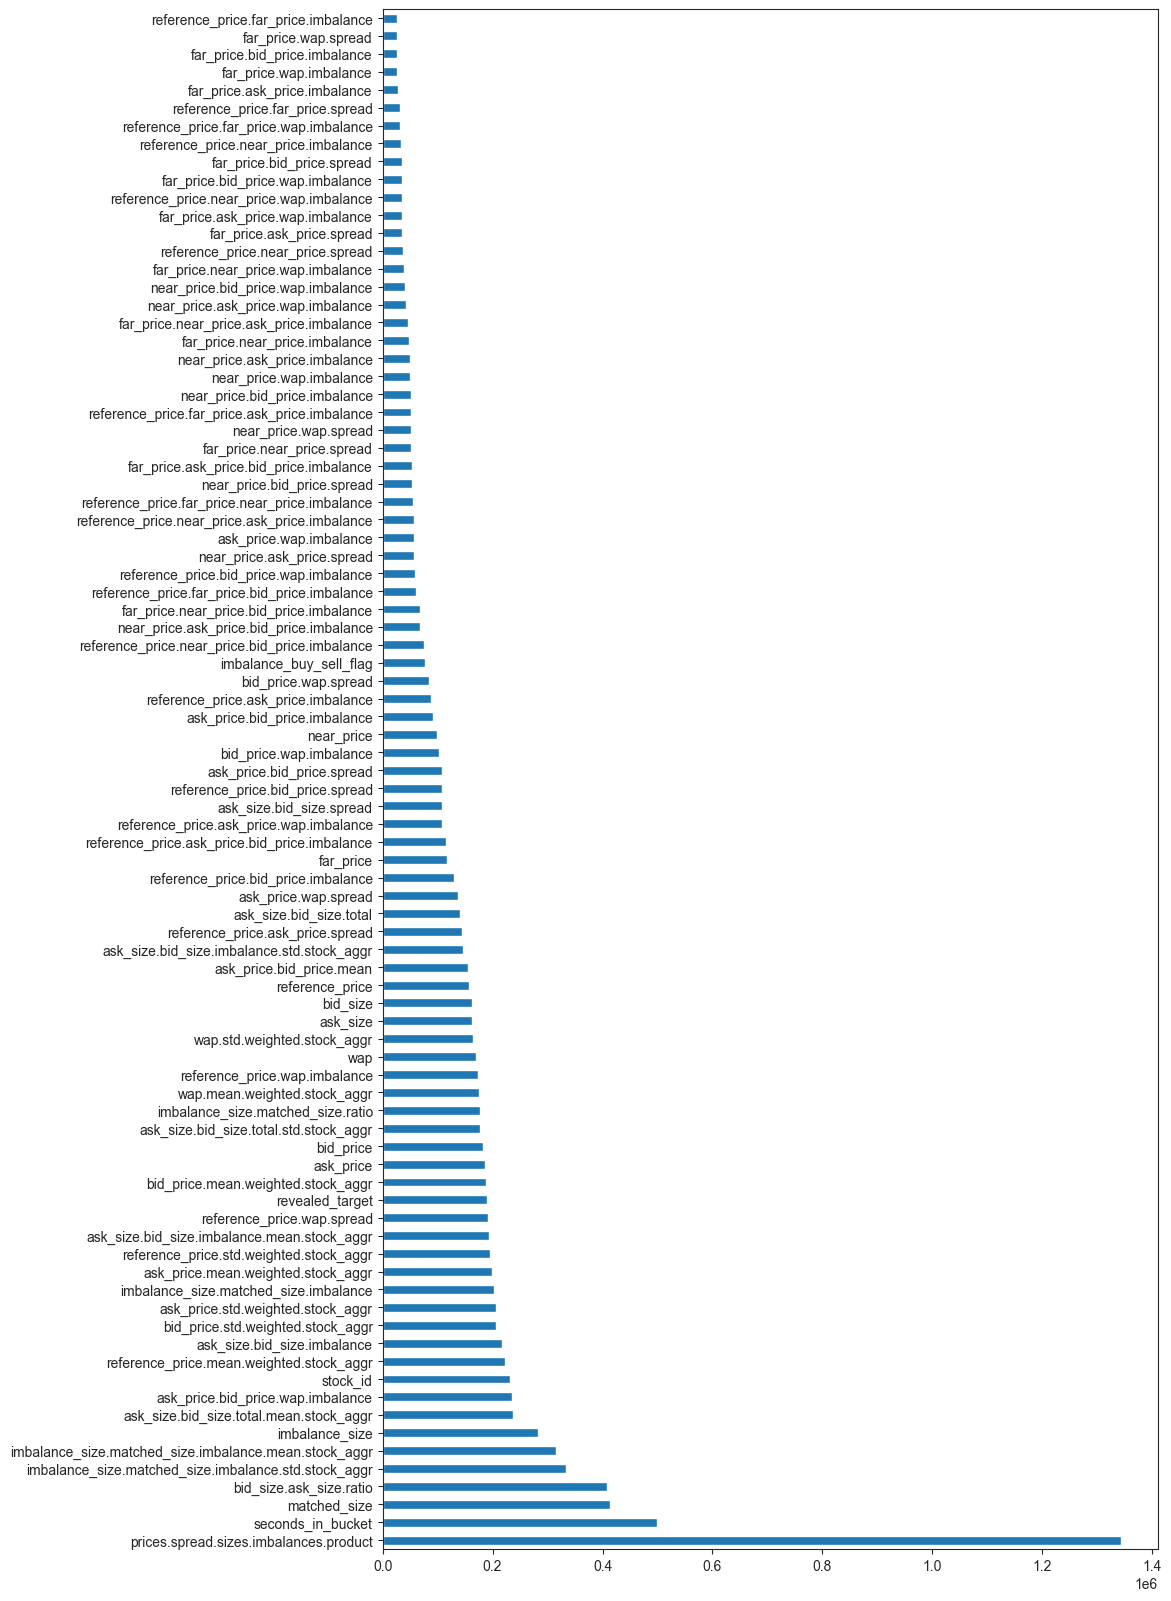

In [15]:
agreggated_feature_importances = (sum([model.booster_.feature_importance(importance_type="gain") \
                                       for model in trained_models])/len(trained_models)).astype(np.int32)

agreggated_feature_importances = pd.Series(agreggated_feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 20))
agreggated_feature_importances.plot(kind='barh')